***Creator: Changhee Kang***

**Part 1 - Studying unknown variables with assumptions**

**Note that** data manupulation and exploration techniques illustrated in this demonstraton does not mean that the audience have to follow the same ways as shown here. 

# Device Failure and Maintenance Prediction Model

It is to build a predictive model with diagnoses of telemetry attributes to classify whether maintenance should be performed on devices or not. The column used for prediction is set with the column name, "failure",  with binary value 0 for "non-failure" and 1 for "failure". ***The goal is to minimize false positives and false negatives.***

# Assumption

As there is no meta data for the description of the current dataset, assumptions can be applied to the current dataset. The dataset consists of diagnoses of telemetry attributes, so it might be rational that some variables are assumed to consist of *categorical nominal type values* while other variables would consist of *continuous type values*. 

# Roadmap

This demonstration is to show how to handle datasets which are imbalanced. The provided dataset has no  description for variables. The dataset will be analyzed by using various statistical approaches. The main issue with the current dataset is that it is highly imblanaced. Imbalanced datasets are difficult to handle for a predictive model especially when there is really a small number of data points for the minority class in the dataset.

Various sampling techniques usually applied to the imbalanced dataset for a cure to build a predictive model with it. There will be detailed explanations for each sampling technique as the analyses progresses further. In this demonstration, data exploration will only be extensively explained. In the following successive sections, first, no sampling technique will be applied in this demonstration to understand how sampling techniques will affect performances of the predictive model on an imblanaces dataset. Although data preprocessing is done for most datasets but there will be no data preprocessing for this demonstration. 

Additive variable generations such as day, day of the week, month, device operation days, or season from the *'date'* variable could be an option to enhance the model performance. However, additivie variable generations does not always have to be applied to introduce new variables to the original dataset, unless there is any acceptable model performance with the orginal dataset. One could introduce additive variables before any model development but there is no guarantee that those additive variables are going to improve the model performances. 

However, it should be noted that normalizations for continuous values shoud not be confused with additive variable generations. One might be also tempted to apply binning to continuous values but it sould be applied when there is some group or some groups of values that are significantly different from other groups of values in a continuous variable. Otherwise, binning would not be much help and it will only cause lose of information of continuity in the values. Distribution transformations, for example, log-normal transformation, could be used but it is not neccessary to be applied for Randome Forest learning algorithm. It all depends on what the analyzer intend to do with the dataset.

Logsitic Regression and Neural Network based algorithms could also have been used but assuming that values of some variables are categorical nominal type values, to properly use those algorithms, creating dummy or one-hot-encoded variables for those algorithms simply overwhelms contraints on the given task. Therefore, for the predictive model development, instead of using Losigitic Regression or Neural Network based algorithms, Random Forest predictive model learning algorhtm will be adopted because Random Forest can handle very well for both categorical nominal type values and continuous type values at the same time. In addition, Random Forest does not necessarily require continuous type values to be normalized.

# Data Loading

import necessary python modules.

In [25]:
import pandas as pd
import numpy as np

Load the dataset into memory.

In [26]:
datafile = r'/home/thomas/Downloads/device_failure.csv'
dataset = pd.read_csv(datafile, sep=',', engine='python')

# Data Exploration

See if the dataset has been loaded correctly. There should be 12 columns meaning 12 variables. 

In [3]:
dataset.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


Take a look at the number of total records.

In [4]:
dataset.failure.count()

124494

Take a look at the data structure.

In [5]:
dataset.dtypes

date          object
device        object
failure        int64
attribute1     int64
attribute2     int64
attribute3     int64
attribute4     int64
attribute5     int64
attribute6     int64
attribute7     int64
attribute8     int64
attribute9     int64
dtype: object

There are 12 variables in the dataset. All of the variables in the dataset are all integer values except date and device variables. Let's take a look at the distribution of the dataset in terms of failure and non-failure.

In [6]:
value_distribution = dataset.failure.value_counts()

In [7]:
print("Non-failure: {} [{:.2f}%]".format(value_distribution[0], (value_distribution[0]/dataset.failure.count())*100))
print("Failure: {} [{:.2f}%]".format(value_distribution[1], (value_distribution[1]/dataset.failure.count())*100))

Non-failure: 124388 [99.91%]
Failure: 106 [0.09%]


In [8]:
value_distribution.plot(kind='bar')

The number of device failures is less than 0.1% and the dataset appears to be highly imbalanced. As shown above, there are 12 varaibles. Failure is the target variable and 11 variables are considered to be independent variables. All the independent variables seems to be integers. The next things to do is to see if there are any null values or missing values in columns of the dataset. The following two lines will figure out if there any null and missing values in the dataset.

In [30]:
dataset.isnull().any()

date          False
device        False
failure       False
attribute1    False
attribute2    False
attribute3    False
attribute4    False
attribute5    False
attribute6    False
attribute7    False
attribute8    False
attribute9    False
dtype: bool

In [31]:
dataset.isna().any()

date          False
device        False
failure       False
attribute1    False
attribute2    False
attribute3    False
attribute4    False
attribute5    False
attribute6    False
attribute7    False
attribute8    False
attribute9    False
dtype: bool

In order to confirm that there are no missing and null values in every variable, the following can be executed for a list of all the summations of each column:

In [32]:
dataset.isnull().sum()

date          0
device        0
failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
dtype: int64

It is clear to say that there are no null values in the dataset. Currently the meaning of each variable is unknown and it is definitely required to explore each variable to find out what each variable would mean. There are 106 samples, approaximately 0.0852%, indicating failure. The above distribution shows that the dataset is perfectly imbalanced. In order to grasp the overall representation of the dataset, it is favorable to look into the characteristics of each variable, first. The following lines will first reveal the number of unique values in each variable and will give an overall idea of how each variable contributes to failure and non-failure.

In [169]:
# Show distinct values of each variable.
columns = dataset.columns
no_unique_values = []
for column in columns:
    unique_values = np.unique(dataset[column])
    print('{}: {} distinct values -  {}'.format(column, len(unique_values), unique_values))
    no_unique_values.append(len(unique_values))

date: 304 distinct values -  ['2015-01-01' '2015-01-02' '2015-01-03' '2015-01-04' '2015-01-05'
 '2015-01-06' '2015-01-07' '2015-01-08' '2015-01-09' '2015-01-10'
 '2015-01-11' '2015-01-12' '2015-01-13' '2015-01-14' '2015-01-15'
 '2015-01-16' '2015-01-17' '2015-01-18' '2015-01-19' '2015-01-20'
 '2015-01-21' '2015-01-22' '2015-01-23' '2015-01-24' '2015-01-25'
 '2015-01-26' '2015-01-27' '2015-01-28' '2015-01-29' '2015-01-30'
 '2015-01-31' '2015-02-01' '2015-02-02' '2015-02-03' '2015-02-04'
 '2015-02-05' '2015-02-06' '2015-02-07' '2015-02-08' '2015-02-09'
 '2015-02-10' '2015-02-11' '2015-02-12' '2015-02-13' '2015-02-14'
 '2015-02-15' '2015-02-16' '2015-02-17' '2015-02-18' '2015-02-19'
 '2015-02-20' '2015-02-21' '2015-02-22' '2015-02-23' '2015-02-24'
 '2015-02-25' '2015-02-26' '2015-02-27' '2015-02-28' '2015-03-01'
 '2015-03-02' '2015-03-03' '2015-03-04' '2015-03-05' '2015-03-06'
 '2015-03-07' '2015-03-08' '2015-03-09' '2015-03-10' '2015-03-11'
 '2015-03-12' '2015-03-13' '2015-03-14' '2015-0

**Summary of unique values**

- date : 304 unique values.
- devce: 1,169 unique values.
- attribute1: 123,877 unique values.
- attribute2: 558 unique values.
- attribute3: 47 unique values.
- attribute4: 115 unique values.
- attribute5: 60 unique values.
- attribute6: 44,838 unique values.
- attribute7: 28 unique values.
- attribute9: 65 unique values.

For a dataset with a large number of variables, it would be extremly hard to manually look at all the values of each variable in the dataset. Nonetheless, data exploration for understanding characteristics of individual variables is mandatory to undergo when a story telling about the current dataset is required. However, the current dataset only has 9 variables excluding *'date'*, *'device'*, and *'failure'* variables, so it is reasonble to look at individual characteristics of unique values of each variable.

- *'attribute1'* and *'attribute6'* have relatively high numbers of unique values while numbers of unique values for other values are small. Those two variables must have a lot of ways for the predictive model to learn non-failures of devices. The predictive model must not only know how to tell devices with failure but it also has to learn ways to failure, too. A brief unique value summary will help grasp a further picture of the dataset.


- The ranges of unique values of *'attribute1'* and *'attribute6'* are much broader than the ranges of unique values of other variables. 


- *'attribute7'* and *'attribute8'* seem to be idential to one another. Either of the variables, *'attribute7'* or *'attribute8'*, should be removed from analysis if those variables are used by Logistic Regression or Ordinal Regression since those two analyses strongly assume little or no multicollinearity. 


- *'attribute1'* appears to be multiples of *'attribute2'*, either of those two variables should also be remove from the dataset unless only one of them shoudl be used. Otherwise, they will cause a multicollinearity problem if Logistic Regression or Ordinal Regression analyses are implemented for the predictive model. *'attribute1'* seems to express the amount of daily data transmission handled by each device. 


- Although Logistics Regression and Ordinary Regression are not applied here, but those multi-collinearity issues should be noted. When Logsitics Regression or Ordinary Regression is undertaken, multi-collinearity tests must be performed for a reliable multi-collinearity assiciation to ensure the predictive model performance. 

Let's first check if *'attribute7'* and *'attribute8'* are identical to one another. 

In [23]:
# Create two different dataframes for attribute7 and attribute8.
attribute_7 = pd.DataFrame(dataset, columns = ['attribute7'])
attribute_8 = pd.DataFrame(dataset, columns = ['attribute8'])
attribute_test = pd.DataFrame(dataset, columns = ['matched'])

# Compare attribute7 and attribute8 by their values for each record.
attribute_test['matched'] = pd.DataFrame(np.where(attribute_7.attribute7 == attribute_8.attribute8, 'True', 'False'))

In [24]:
# See the number of matched values.
attribute_test['matched'].value_counts()

True    124494
Name: matched, dtype: int64

It is safe to say *'attribute7'* is a duplicate of *'attribute8'* or the other way around. As mentioned earlier above, if a variable is a copy of another variable, it could be problematic when the predictive model is developed using Logistic Regression Classifier since Logistic Regression assumes little or no multi-collinearity among independent variables, so either of them should be removed from the dataset or they both can stay in the dataset as long as only one of them is applied to the model development. 

If the model is developed by using a ensemble classfier such as Random Forest, the effect of multi-collinearity would not have much impact on the preditive model since Random Forest will create the predictive model with random selection of features at each node creation, but in general the effect is not removed completely. It could be experimented during the model development.

It would be useful if the overall number of unique values in each variable could be presented with graphical representations. A pie chart and a bar chart would do the trick to quickly understand the overall characteristics of distributions of unique values in the dataset.

In [11]:
# import matplotlib to plot graphical statistics.
import matplotlib.pyplot as plt

In [27]:
'''
    It returns an array of numbers of unique values in each variable.
'''
def get_no_unique_values(columns):
    no_unique_values = []
    for column in columns:
        no_unique_value = dataset[column].nunique()
        no_unique_values.append(no_unique_value)
    return no_unique_values

'''
    Plot a bar chart for the number of unique values in each variable.
    Numbers of unique values of each variable will also be displayed on top of each bar,
    otherwise those small values would have no way to display themselves.
'''
def plot_no_unique_values_bar_chart(columns):
    no_unique_values = get_no_unique_values(columns)
    total_no_unique_value = sum(no_unique_values)
    percentages = []
    
    for value in no_unique_values:
        percentages.append(round((value/total_no_unique_value)*100, 4))
        
    fig, ax = plt.subplots()
    percent_idx = 0
    for i, v in enumerate(no_unique_values):
        ax.text(v + 3, i + .25, str(v)+str("  (")+str(percentages[percent_idx])+str("%)"), color='green')
        percent_idx += 1

    width = 0.65 # the width of the bars 
    ind = np.arange(len(no_unique_values)) 
    ax.barh(ind, no_unique_values, width, color="blue")
    ax.set_yticks(ind+width/2)
    ax.set_yticklabels(columns, minor=False)
    plt.title('No. of unique values by variable')
    plt.xlabel('No. of unique values')
    plt.ylabel('Variables') 
    plt.show()

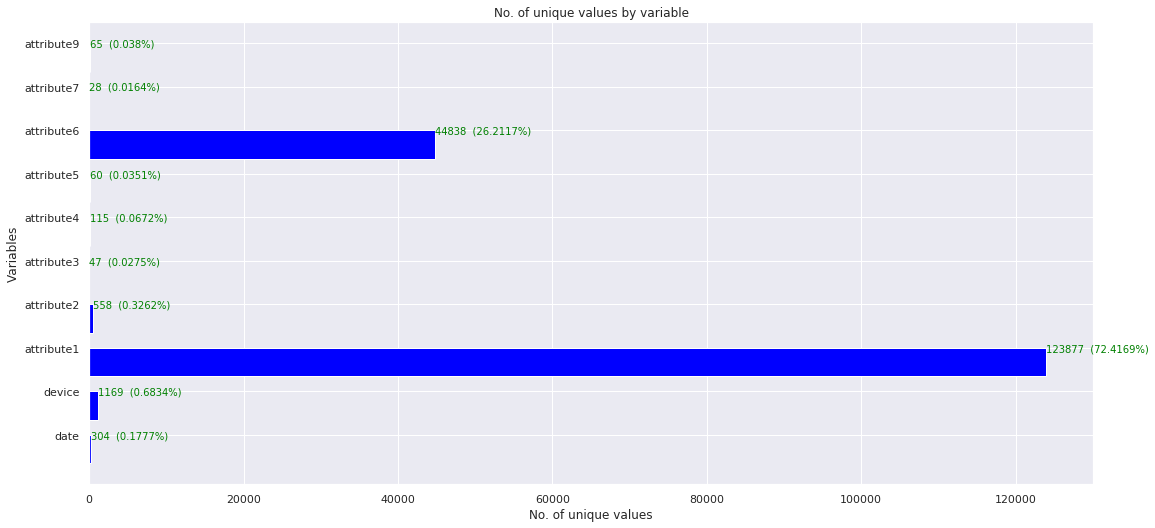

In [31]:
'''
    attribute8 is removed from the column list since it is a duplicate of attribute7.
'''
columns = ['date',       'device',     'attribute1',
           'attribute2', 'attribute3', 'attribute4', 
           'attribute5', 'attribute6', 'attribute7', 
           'attribute9'] 

'''
    Generate a bar chart for more details with counts of unique values in each variable. 
'''
plt.rcParams['figure.figsize'] = (18.0, 8.5)
plot_no_unique_values_bar_chart(columns)

- *'attribute1'* and *'attribute6'* have large numbers of unique values while other variables have relatively small numbers of unique values. 
- Unique values of *'attribute1'* are assumed to be the amount of daily data exchange. *'attribute6'* also a large number of unique values but it is not really conclude what *'attribute6'* means. 
- It seems reasonable to consider unique values of *'attribute1'* and *'attribute6'* as continuous values.
- *'attribute2'* has 558 unique values and *'attribute4'* has 115 unique values. 
- Treating unique values of *'attribute2'* as a continuous values seems to be rational. 
- *'attribute3'*, *'attribute4'*, *'attribute5'*, 'attribute7'*, and 'attribute9'* are assumed to be categorical nominal type vaues. discrete values of those variables could be treated as continuous type values but in this demonstration, they are forced to be categorical nominal type values to apply a variety of modeling approaches. 

*'attribute1'*, *'attribute2'*, and *'attribute6'* are considered to be continuous type values while *'attribute3'*, *'attribute4'*, *'attribute5'*, 'attribute7'*, and 'attribute9' are assumed to be categorical nominal value types. Recall that 'attribute8'* is not included because *'attribute8'* is identical to *'attribute7'*. One can use both *'attribute7'* and *'attribute8'* if Random Forest is the learning algorithm but for this demonstration, *'attribute8'* will not be used. 

## Categorical Variable Exploration

Unique values, contributing to failure, of each variable will be studied. The following uitility functions will help plot the distribution of contributions of unique values in each variable.

In [247]:
total_record = dataset['failure'].count() # Get a count for total records.
failure_summary_table = [["Variable", "Total", "Failure", "Non-failure", "Intersected"]] # a summary table.

'''
    This will plot statistics on unique values with failure contribution.
'''
def plot_unique_value_contribution_device_failure(attr):
    
    '''
        Prepare dataframe from the original dataset for required statistics.
    '''
    plt.rcParams['figure.figsize'] = (18.0, 3.5)
    attr_failure_info = dataset['failure'] == 1
    df1 = pd.DataFrame(dataset, columns=[attr])
    df2 = pd.DataFrame(dataset[attr_failure_info], columns=[attr])
    attr_failure_info = dataset[attr_failure_info].groupby(attr).failure.sum()

    '''
        Compute necessary information to generate summary statistics on unique values with 
        contributions to both failure and non-failure.
    '''
    total_no_uniq_values = dataset[attr].nunique()
    unique_value_ratio = round((total_no_uniq_values/total_record)*100, 4)
    failures = attr_failure_info.count()
    failure_ratio = round((failures/total_no_uniq_values)*100, 4)
    non_failures = total_no_uniq_values - failures
    non_failure_ratio = round((non_failures/total_no_uniq_values)*100, 4)
    intersection_df = pd.merge(df1, df2, on=[attr], how='inner')
    intersection = intersection_df[attr].nunique()
    intersection_ratio = round((intersection/failures)*100, 4)
    
    '''
        Store summaries on unique values with failure contribution.
    '''
    tr = ['{}'.format(attr), 
          '{:,}({:.2f}%)'.format(total_no_uniq_values, unique_value_ratio),
          '{:,}({:.2f}%)'.format(failures, failure_ratio),
          '{:,}({:.2f}%)'.format(non_failures, non_failure_ratio),
          '{:,}({:.2f}%)'.format(intersection, intersection_ratio)
         ]
    failure_summary_table.append(tr)

In [248]:
# See how unique values in attribute3 contributes to failure. 
plot_unique_value_contribution_device_failure('attribute3')
plot_unique_value_contribution_device_failure('attribute4')
plot_unique_value_contribution_device_failure('attribute5')
plot_unique_value_contribution_device_failure('attribute7')
plot_unique_value_contribution_device_failure('attribute9')

Let's take a look at the summary of category variable analyses.

In [249]:
from IPython.display import HTML, display
import tabulate

In [250]:
display(HTML(tabulate.tabulate(failure_summary_table, tablefmt='html')))

Variable,Total,Failure,Non-failure,Intersected
attribute3,47(0.04%),7(14.89%),40(85.11%),7(100.00%)
attribute4,115(0.09%),40(34.78%),75(65.22%),40(100.00%)
attribute5,60(0.05%),28(46.67%),32(53.33%),28(100.00%)
attribute7,28(0.02%),16(57.14%),12(42.86%),16(100.00%)
attribute9,65(0.05%),14(21.54%),51(78.46%),14(100.00%)


Those variables in the summary are all assumed to have categorical nominal type values. All the category variables have high cardinarities, meaning that those category variables have a large number of unique categorical values. 

The predictive model needs to classify devices into either failure or non-failure. Looking at the summary above, *'attribute3'* will be the most importance variable for the predictive model to learn that a device is either in failure or non-failure since it has the highest number of intersected unique values. Having a higher number of intersected unique values for a categorical variable means that the predictive model knows many ways to tell if a device is in failure or non-failure. The rank of variable importances will follow high numbers of intersected unique values in each variable.

In addition to the summary above, it might a good idea to look at numerical categorical variable importance measures by using *'ExtraTreesClassifer'* in *'sklearn'* and compare the numerical feature importances to the summary above. 

In [217]:
# import ExtraTreesClassifier.
from sklearn.ensemble import ExtraTreesClassifier

In [223]:
# Test features for importances.
def examine_features(x_train, y_train):
    # Build a forest and compute the feature importances
    forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
    forest.fit(x_train, y_train)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    for f in range(X.shape[1]):
        print("%d. attribute %d (%f)" % (f + 1, indices[f] + 1, importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.rcParams['figure.figsize'] = (18.0, 4.5)
    plt.figure()
    plt.title("Feature importance scores")
    plt.bar(range(X.shape[1]), importances[indices], color="red", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices+1)
    plt.xlim([-1, X.shape[1]])
    plt.show()

Feature ranking:
1. attribute 1 (0.278196)
2. attribute 6 (0.276792)
3. attribute 4 (0.123269)
4. attribute 2 (0.102534)
5. attribute 5 (0.082676)
6. attribute 7 (0.079533)
7. attribute 8 (0.044559)
8. attribute 3 (0.012441)


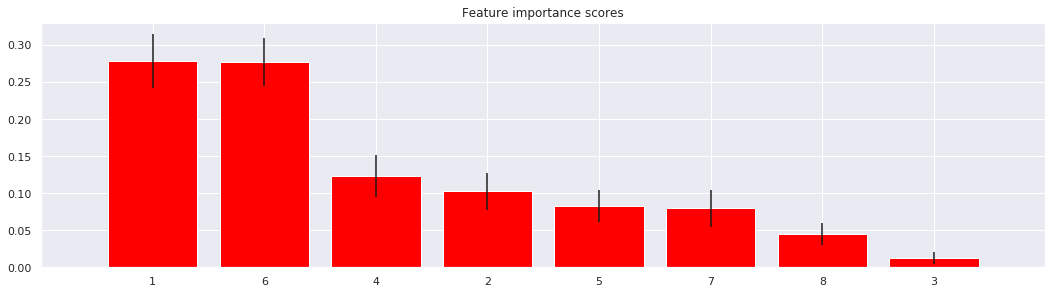

In [224]:
# Execute variable importance test with all the variables in the current dataset.
X = dataset[['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']]
Y = dataset.failure
examine_features(X, Y)

The numeric variable importance test with ExtraTreesClassifier shows the order of important variables according to the variable importance score of each variable. As mentioned above, it is conclusive that variables with a higher number of intersected unique values take higher variable importance scores. Knowing numerical importances of variables gives more confidence in choosing variables to include or exclude when developing the predictive model. With these understandings about variables in the current dataset, diving deeper into the spreads of unique values on failure and non-failure would give more insights to further understand about the variables. Although boxplots are for continuous values, boxplots can be improvised to look at the spreads of unique values of categorical variables, too. Note that one can use *'Logistic Regression'" to display the spread of values separately.

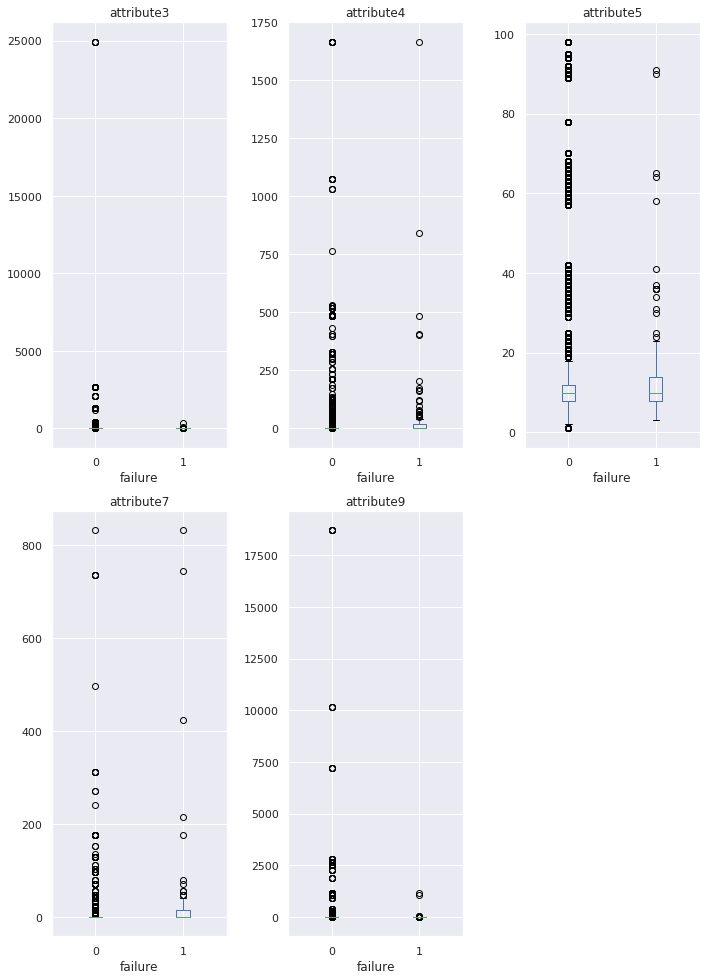

In [253]:
fig = plt.figure(figsize=(10,20))

ax1 = plt.subplot(331)
ax2 = plt.subplot(332)
ax3 = plt.subplot(333)
ax4 = plt.subplot(334)
ax5 = plt.subplot(335)

dataset.boxplot(column='attribute3',by='failure',ax=ax1)
dataset.boxplot(column='attribute4',by='failure',ax=ax2)
dataset.boxplot(column='attribute5',by='failure',ax=ax3)
dataset.boxplot(column='attribute7',by='failure',ax=ax4)
dataset.boxplot(column='attribute9',by='failure',ax=ax5)

plt.suptitle('')
plt.tight_layout()

By looking at the boxplots above, *'attribute4'*, *'attribute5'*, and *'attribute7'* seem to have more options to contribute to failure than other variables: *'attribute3'* and *'attribute9'*. Above boxplots reveal that the unique value, *'0'*, or close to *'0'* in *'attribute3'*, and *'attribute9'* show that has most frequencies for both failure and non-failure while *'attribute4'*, *'attribute5'*, *'attribute7'* show similar spread patterns of their unique values except ranges of spreads of their unique values. From the study of variables, *'attribute4'*, *'attribute5'*, and *'attribute7'* could be good to use for the predictive model developments since they have more distinctive ways to failure and have more distinctive spreads of unique values than unique values of other categorical variables for non-failure.